In [1]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

# LIBRARIES

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import pandas as pd
import time

from tensorflow_probability.substrates import numpy as tfp
tfd = tfp.distributions

np.random.seed(0)

# LOAD DATA

In [3]:
sampled_perturbed = np.load('sampled_2D_two_clusters.npy')

In [4]:
sampled_true = np.load('sampled_2D_two_clusters_true.npy')

In [25]:
data = sampled_perturbed[0 : 1000]

In [6]:
#DEFINING NUMBER OF CLUSTERS AND DIMENSION OF DATA
k = 10
d = 2

# GIBBS SAMPLER

In [24]:
#FUNCTION TO RUN ONE GIBBS SAMPLER ITERATION
#TAKES IN INPUT VALUES OF THE PREVIOUS ITERATION AND SAMPLE THE NEW VALUES BY THE FUNCTIONS sample_uniq_vals_fullcond, update_weights and update_cluster_allocs
#RETURN:  -cluster_allocs: A VECTOR WITH FOR EVERY DATA POINT THE CLUSTER TO WHICH IT IS ASSIGNED
#         -uniq_vals: A MATRIX WITH #ROWS=CLUSTERS AND 2 COLUMNS, IN EACH COLUMN THERE IS AN ARRAY LIKE [MU[0], VAR[0,0], VAR[0,1]]
#         -weights: A VECTOR WITH THE WEIGHTS OF THE CLUSTERS

def run_one_gibbs(data, cluster_allocs, uniq_vals, weights, alpha, lam):

    n_clus = len(weights)
    
    for h in range(n_clus):
        clusdata = data[cluster_allocs == h]
        if len(clusdata) == 0:
            uniq_vals[h, :] = sample_uniq_vals_prior(lam)
        else:
            uniq_vals[h, :] = sample_uniq_vals_fullcond(clusdata, lam)
    
    weights = update_weights(cluster_allocs, n_clus, k, alpha)
    
    cluster_allocs = update_cluster_allocs(data, weights, uniq_vals)
    
    return cluster_allocs, uniq_vals, weights


# FUNCTION TO RUN THE ENTIRE MARKOV CHAIN
# TAKES IN INPUT DATA, NUMBER OF CLUSTERS, NUMBER OF ITERATIONS, BURN-IN AND THIN
# IT INITIALIZE THE PARAMETERS AND THEN AT EACH ITERATION CALLS THE FUNCTION run_one_gibbs
# AFTER THE BURN IN IT COLLECT THE PARAMETERS IN THREE LISTS
# RETURN THE LISTS

def run_mcmc(data, k, niter=2500, nburn=500, thin=5):   
    b = time.time() # only to measure time
    
    cluster_allocs = tfd.Categorical(probs=np.ones(k) / k).sample(len(data))
    weights = np.ones(k) / k
    alpha = 0.1
    lam = 0.1
    
    # 4  bivariate normal e 4 matrices 2x2
    uniq_vals = np.dstack([
        tfd.MultivariateNormalFullCovariance(np.mean(np.array(data), axis=0), np.linalg.inv(np.diag(np.ones(d))/lam)).sample(k),
        tfd.WishartTriL(df=d, scale_tril=tf.linalg.cholesky(np.diag(np.ones(d))) ).sample(k)])
    
    allocs_out = []
    uniq_vals_out = []
    weights_out = []
    
    for i in range(niter):
        cluster_allocs, uniq_vals, weights = run_one_gibbs(
            data, cluster_allocs, uniq_vals, weights, alpha, lam)
        
        if i > nburn and i % thin == 0:
            allocs_out.append(cluster_allocs)
            uniq_vals_out.append(uniq_vals.copy())
            weights_out.append(weights)
            
        if i % 10 == 0:
            a = time.time()
            print("\rIter {0} / {1}".format(i+1, niter) + " Remaining minutes: " + str(round((a-b)*(niter-i)/(60*10) ,1)) , flush=False, end=" ")
            b = time.time()
            
    return allocs_out, uniq_vals_out, weights_out

In [9]:
# FUNCTION TO UPDATE THE CLUSTER ALLOCATIONS
# IT EVALUATE THE MIXTURE ON THE DATA AND COMPUTE THE NEW PROBABILITIES FOR EACH CLUSTER AND RETURN THE NEW ALLOCATIONS

def update_cluster_allocs(data, weights, uniq_vals):
    
    logprobs = tfd.MultivariateNormalFullCovariance(uniq_vals[:,:,0], uniq_vals[:,:,1:3]).log_prob(data[:, np.newaxis])
    logprobs += np.log(weights)
    probs =  np.exp(logprobs)/np.sum(np.exp(logprobs), axis=1)[:,None]
    for i in range(len(probs)):
        if np.all(probs[i] == 0):
            probs[i] = np.ones(k) / k
    return tfd.Categorical(probs=probs, validate_args=True).sample()


# FUNCTION TO UPDATE THE WEIGHTS 
# IT UPDATES THE PARAMETERS OF THE DIRICHLET AND RETURNS THE NEW WEIGHTS
def update_weights(cluster_allocs, n_clus, k, alpha):

    n_by_clus = np.array([np.sum(cluster_allocs == h) for h in range(n_clus)])
    post_params = np.ones(k) * alpha + n_by_clus
    return tfd.Dirichlet(post_params.astype(float)).sample()


# FUNCTIONS TO SAMPLE FROM THE PRIORS AND FROM THE FULL CONDITIONALS
# THEY BOTH USE THE CHOLESKY FACTORIZATION FOR THE NEW COVARIANCE MATRIX AND THEN SAMPLE FROM A WISHART(COV MATRIX) AND MULTIVARIATE NORMAL(MEAN)
# RETURN AN ARRAY OF ARRAYS
def sample_uniq_vals_prior(lam):
    
    chol = tf.linalg.cholesky(np.diag(np.ones(d))) 
    prec = tfd.WishartTriL(df=d, scale_tril=chol).sample()
    var = np.array(tf.linalg.inv(prec))
    mu = tfd.MultivariateNormalFullCovariance(np.mean(np.array(data), axis = 0), var/lam).sample()
    return np.array([[mu[0], var[0,0], var[0,1]],[mu[1], var[1,0], var[1,1]]])
    

def sample_uniq_vals_fullcond(clusdata, lam):
    
    n=len(clusdata)
    W0 = np.diag(np.ones(d))
    C = (n-1)*np.cov(clusdata, rowvar = False)
    D = lam*n/(lam+n)*np.dot(np.mean(clusdata, axis = 0)-np.mean(data, axis = 0),np.mean(clusdata, axis = 0)-np.mean(data, axis = 0))
    W = tf.linalg.inv(W0 + C + D)
    chol = tf.linalg.cholesky(W) 
    prec = tfd.WishartTriL(df=d+n, scale_tril=chol).sample()
    var = np.array(tf.linalg.inv(prec))
    mu = tfd.MultivariateNormalFullCovariance((lam * np.mean(np.array(data), axis = 0)+n*np.mean(clusdata, axis = 0))/(lam+n), var/(lam+n)).sample()
    return np.array([[mu[0], var[0,0], var[0,1]],[mu[1], var[1,0], var[1,1]]])


In [28]:
#RUNNING THE MCMC
allocs_out, uniq_vals_out, weights_out = run_mcmc(data, k)

Iter 2491 / 2500 Remaining minutes: 0.0 

# PLOT OF THE CLUSTERS

5    496
7    258
1    246
dtype: int64


<BarContainer object of 3 artists>

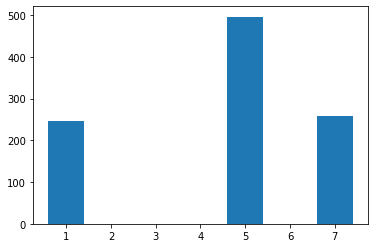

In [29]:
#View the number of points inside each cluster at the final iteration
print(pd.Series(allocs_out[-1]).value_counts())

x, y = np.unique(allocs_out[-1], return_counts=True)
plt.bar(x, y)

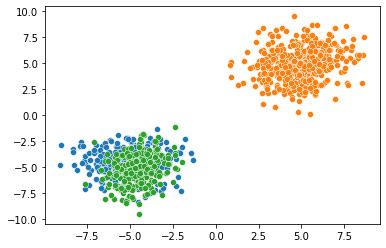

In [30]:
for h in range(k):
    currd = data[allocs_out[-1] == h]
    sns.scatterplot(x=[elem[0] for elem in currd], y=[elem[1] for elem in currd],)

In [36]:
#MEDIE NEI CLUSTER DELL'ULTIMA ITERAZIONE
M = [[np.mean(data[allocs_out[-1] == h][:,0]), np.mean(data[allocs_out[-1] == h][:,1])] for h in range(k)]

# TRACE PLOTS

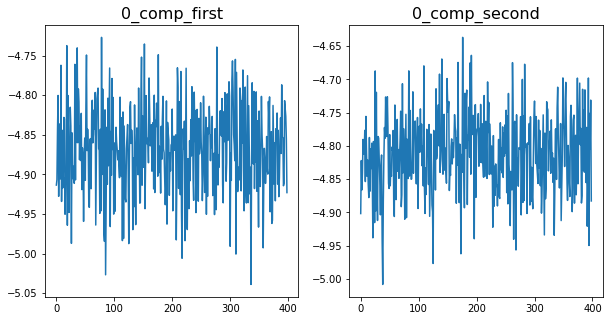

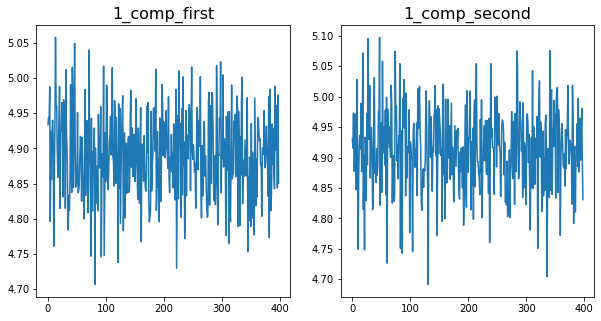

In [37]:
means = [val[:,:,0] for val in uniq_vals_out]
for i in range(len(weights_out[0])):
    

    #Get mean of the first gaussian component
    first_comp = [mean[i,:] for mean in means]

    #Get mu_1 and mu_2 from the first component (multivariate) mean
    first_comp_first = [first_comp_mean[0] for first_comp_mean in first_comp]
    first_comp_second = [first_comp_mean[1] for first_comp_mean in first_comp]

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

    axes[0].plot(np.arange(len(first_comp_first)), first_comp_first)
    axes[0].set_title(str(i) + "_comp_first", fontsize=16)

    axes[1].plot(np.arange(len(first_comp_second)), first_comp_second,)
    axes[1].set_title(str(i) + "_comp_second", fontsize=16)

    plt.show()

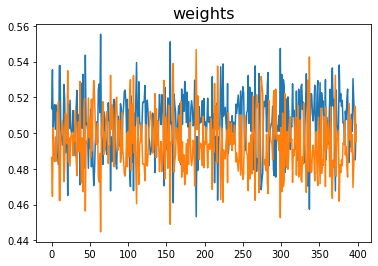

In [38]:
first_weight = [weight[0] for weight in weights_out]
second_weight = [weight[1] for weight in weights_out]
#third_weight = [weight[2] for weight in weights_out]
#fourth_weight = [weight[3] for weight in weights_out]

fig = plt.figure()
ax = fig.add_subplot(111)

ax.plot(np.arange(len(first_weight)), first_weight)
ax.plot(np.arange(len(second_weight)), second_weight)
#ax.plot(np.arange(len(third_weight)), third_weight)
#ax.plot(np.arange(len(fourth_weight)), fourth_weight)
ax.set_title("weights", fontsize=16)


plt.show()